In [1]:
from pathlib import Path
import sys
sys.path.append('../src/rate')
from constants import SCORED_DIR
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from treatment_effects import treatment_effects_pipeline
from utils_plotting import plot_scores, naive_vs_RATE, rewrite_bias, synthetic_plot, sample_rewrites, sample_rewrites_tabular
from utils import load_dataset_from_json, write_to_json
import warnings
warnings.filterwarnings('ignore')

2025-01-29 12:12:57,776 - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-01-29 12:12:57,778 - INFO - NumExpr defaulting to 16 threads.


In [2]:
file_paths = [
    f"{SCORED_DIR}/typos/imdb_vowels_30typos_complete_scored_20241120_162935.jsonl",
    f"{SCORED_DIR}/complete/eli5_length_complete_scored_20240919_170111.jsonl",
    f"{SCORED_DIR}/complete/hh_rlhf_sentiment_scored_complete.jsonl",
    f"{SCORED_DIR}/complete/imdb_sentiment_complete_scored_20240919_152739.jsonl",
    f"{SCORED_DIR}/complete/helpsteer_complexity_complete_scored.jsonl",
    f"{SCORED_DIR}/complete/helpsteer_helpfulness_complete_scored.jsonl"
]

model_key = "ArmoRM"
samples = sample_rewrites(file_paths, model_key)
print(samples)

\subsection*{Imdb_vowels_30typos_complete_scored, 20241120}

\textbf{Reward Question}:
Write a movie review: 

\textbf{Original} (W = 0):
The last reviewer was very generous. I quiet like the first movie, but can't say I enjoy this one very much. The beginning is bearable, but it goes downhill pretty quickly. I just don't see Jon Bon Jovi as a "bad-ass vampire hunter" and the vampire princess is neither sexy nor scary. A lot of the scenes just do not make sense. I mean any normal person would suspect something is up when a strange woman suddenly appearing out of nowhere to seduce you, let alone an experienced hunter. Why Una is able to communicate with Jovi? Nothing was ever explain in this movie, you wouldn't mind if it was entertaining, but that was too much to ask. This has to be one of worst vampire movie I have seen.

\textbf{Rewrite} (W = 1):
An adjustment to the beginning of the review would make it: "I think the last reviewer was very generous. I quite like the first movie, but

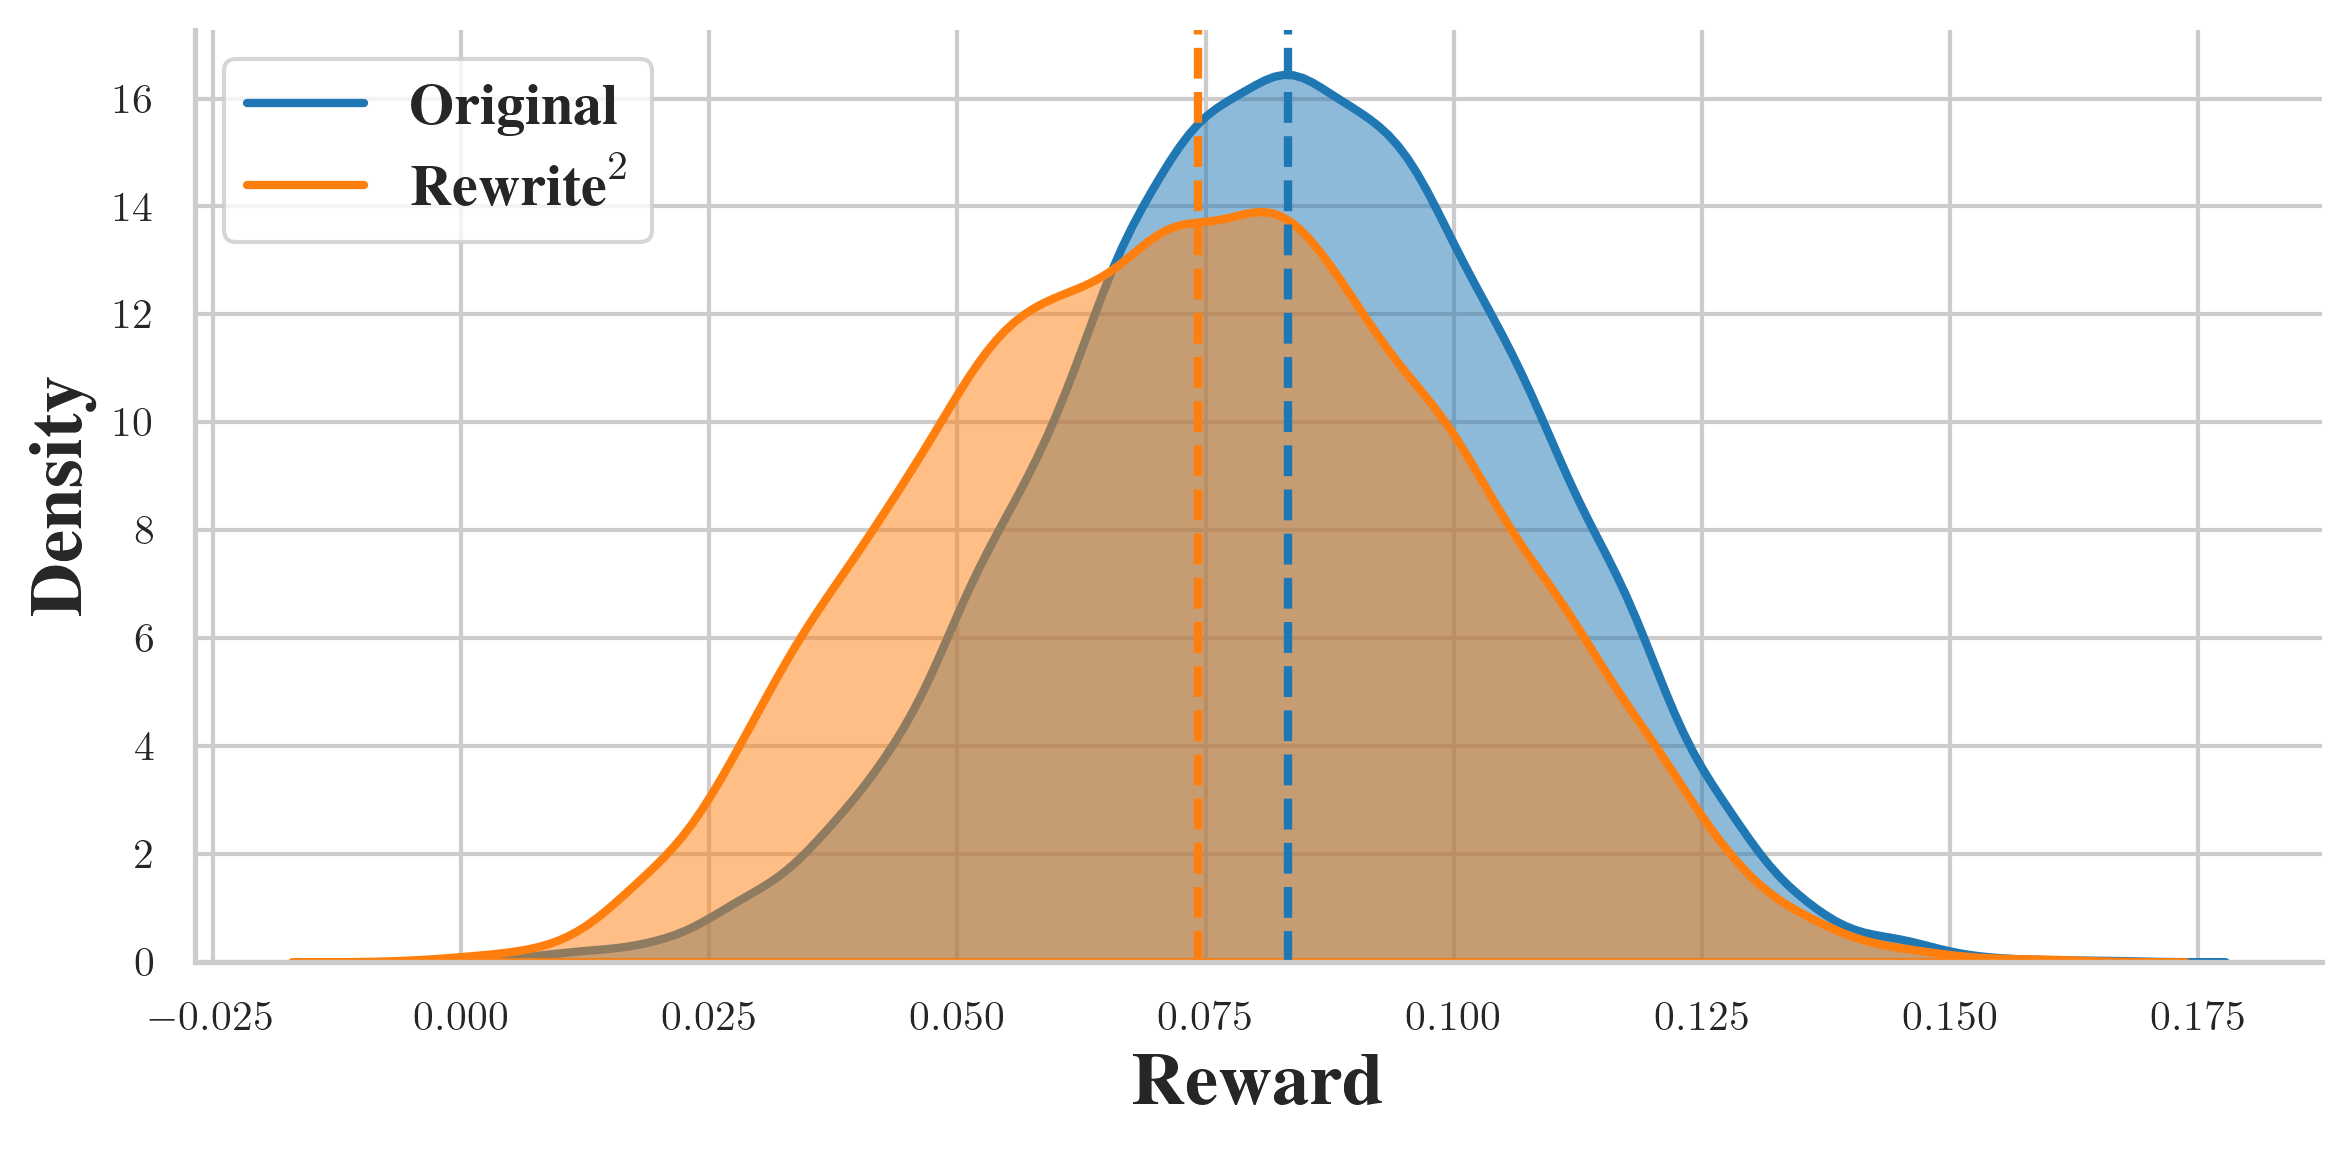

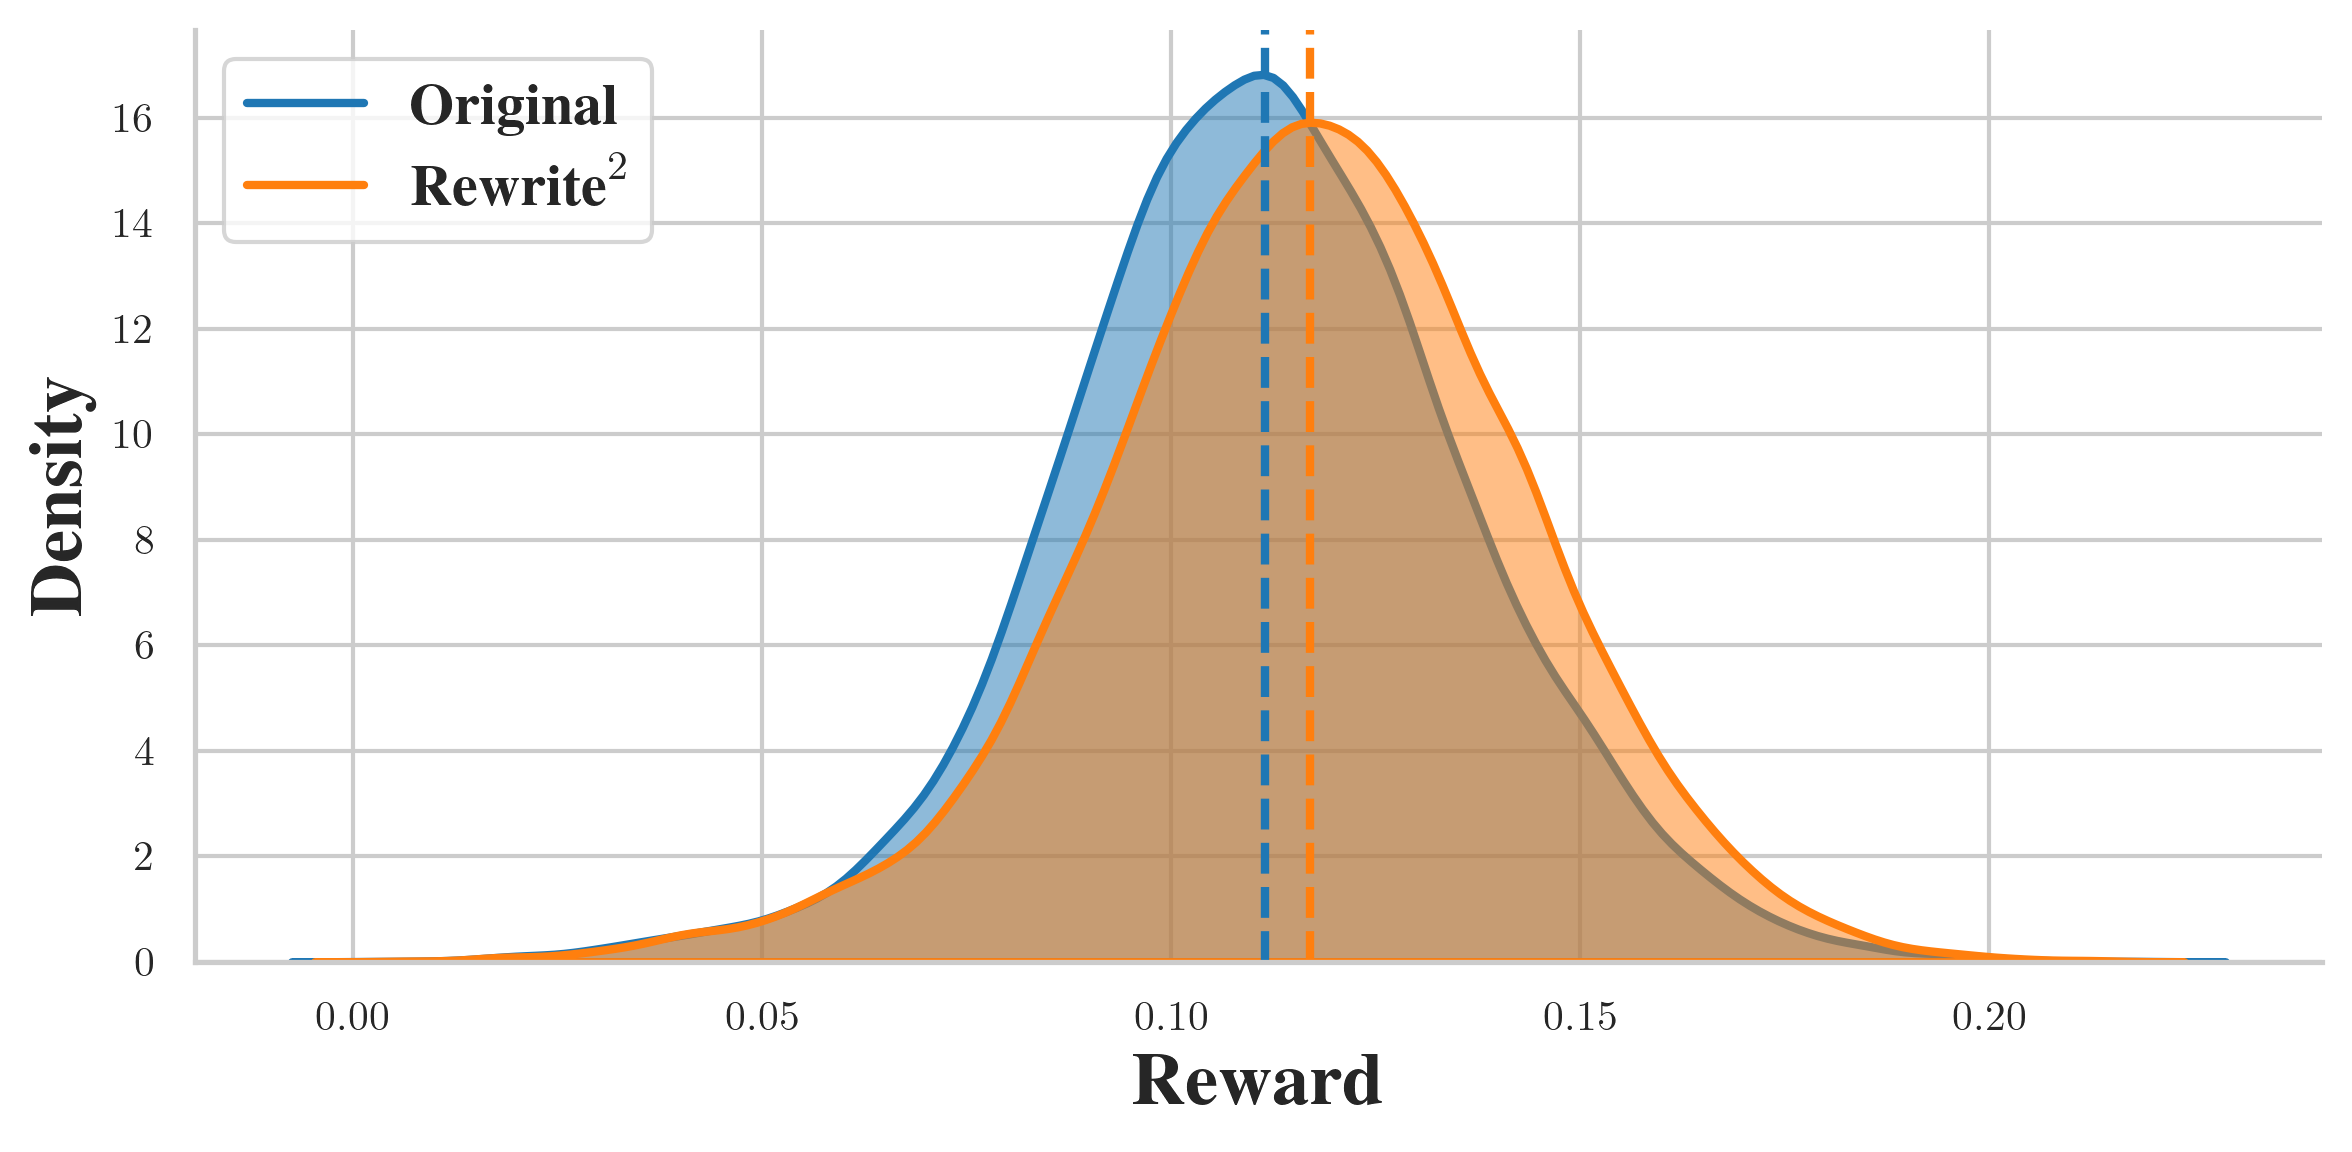

In [3]:
hh_rlhf_template = {
        "dataset_name": "HH-RLHF",
        "concept": "Sentiment",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
    }
eli5_template = {
        "dataset_name": "ELI5",
        "concept": "Length",
        "score": "ArmoRM",
        "reward_key": "ArmoRM",
        "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
    }

plot_scores(hh_rlhf_template, SCORED_DIR)
plot_scores(eli5_template, SCORED_DIR)

In [4]:
# load the json file
data_dir = Path("/net/projects/veitch/prompt_distributions/data/scored")
complete_dir = data_dir / "complete"

eli5_length = load_dataset_from_json(complete_dir / "eli5_length_complete_scored_20240919_170111.jsonl")
helpsteer_complexity = load_dataset_from_json(complete_dir / "helpsteer_complexity_complete_scored.jsonl")
helpsteer_helpfulness = load_dataset_from_json(complete_dir / "helpsteer_helpfulness_complete_scored.jsonl")
hh_rlhf_sentiment = load_dataset_from_json(complete_dir / "hh_rlhf_sentiment_scored_complete.jsonl")
imdb_length = load_dataset_from_json(complete_dir / "imdb_length_complete_scored_20240921_172425.jsonl")
imdb_sentiment = load_dataset_from_json(complete_dir / "imdb_sentiment_complete_scored_20240919_152739.jsonl")

In [5]:
# concatenate the length and sentiment datasets
def concat_datasets(dataset_A, dataset_B):
    # create temp keys for each dataset
    new_dataset_A = {f"A_{key}": value for key, value in dataset_A.items()}
    new_dataset_B = {f"B_{key}": value for key, value in dataset_B.items()}
    # concatenate the two dictionaries
    concatenated_dataset = {**new_dataset_A, **new_dataset_B}
    return concatenated_dataset

# some datasets have d["0"]["RLHFlow/ArmoRM-Llama3-8B-v0.1"] and others d["0"]["ArmoRM"], standardize to the former.
def standardize_ArmoRM(dataset):
    new_dataset = {}
    for key, value in dataset.items():
        # Check if "ArmoRM" exists as a key in the current level of the dictionary
        if "ArmoRM" in value:
            value["RLHFlow/ArmoRM-Llama3-8B-v0.1"] = value.pop("ArmoRM")
        new_dataset[key] = value
    return new_dataset

length = standardize_ArmoRM(concat_datasets(imdb_length, eli5_length))
complexity = standardize_ArmoRM(helpsteer_complexity)
helpfulness = standardize_ArmoRM(helpsteer_helpfulness)
sentiment = standardize_ArmoRM(concat_datasets(imdb_sentiment, hh_rlhf_sentiment))

In [6]:
CONCEPTS = {
    "length": length,
    "complexity": complexity,
    "helpfulness": helpfulness,
    "sentiment": sentiment,
}

REWARD_MODELS = [
    "sfairXC/FsfairX-LLaMA3-RM-v0.1",
    "NCSOFT/Llama-3-OffsetBias-RM-8B",
    "RLHFlow/ArmoRM-Llama3-8B-v0.1"
]

all_data = []
all_templates = []

for concept, dataset in CONCEPTS.items():
    for rm_key in REWARD_MODELS:
        # We set up a minimal template that the pipeline function expects
        # (the pipeline uses e.g. reward_key, original=..., rewrite=..., etc.)
        effects_template = {
            "reward_key": rm_key,
            "w_original_key": "original",
            "w_counterfactual_key": "rewrite",
            "w_rewritten_rewrite_key": "rewritten rewrite",
            "dataset_name": "combined",  # or something descriptive
            "concept": concept,
            "score": rm_key,            # fill in so we know which model
        }

        # Now compute the effects for the entire combined dataset with that reward key
        effects = treatment_effects_pipeline(dataset, **effects_template)

        # Add the concept, model name, etc. so it’s easy to track
        # (the pipeline might already be returning some of this, but just to be sure)
        effects["concept"] = concept
        effects["score"] = rm_key

        all_data.append(effects)
        all_templates.append(effects_template)

2025-01-29 12:05:52,486 - INFO - Number of w=1 examples: 25253
2025-01-29 12:05:52,517 - INFO - Number of w=0 examples: 24748
2025-01-29 12:05:52,624 - INFO - Treatment effects: {   'ATE_rewritten_rewrite': 0.39030453628598316,
    'ATE_rewritten_rewrite_stderr': 0.010139742644725091,
    'ATE_single_rewrite': 0.6908812290673128,
    'ATE_single_rewrite_stderr': 0.005254430242160952,
    'ATT_rewritten_rewrite': 0.5365678994711223,
    'ATT_rewritten_rewrite_stderr': 0.013311674322598655,
    'ATT_single_rewrite': 0.05419359088949527,
    'ATT_single_rewrite_stderr': 0.004397918519562226,
    'ATU_rewritten_rewrite': 0.24105656834860234,
    'ATU_rewritten_rewrite_stderr': 0.015170974159443794,
    'ATU_single_rewrite': 1.3405609174019038,
    'ATU_single_rewrite_stderr': 0.007667693440318097,
    'Y0_count': 24748,
    'Y1_count': 25253,
    'naive_effect': 1.324609282602708,
    'naive_effect_stderr': 0.01192538892765282,
    'reward_std': 1.3355473435068927}
2025-01-29 12:05:52,628 


=== Model: sfairXC/FsfairX-LLaMA3-RM-v0.1 ===
Concept: complexity           | Naive: 0.488 ± 0.020 | RATE: 0.325 ± 0.011
Concept: helpfulness          | Naive: 1.253 ± 0.016 | RATE: 0.393 ± 0.010
Concept: length               | Naive: 0.992 ± 0.009 | RATE: 0.292 ± 0.008
Concept: sentiment            | Naive: 0.448 ± 0.009 | RATE: 0.537 ± 0.007

=== Model: NCSOFT/Llama-3-OffsetBias-RM-8B ===
Concept: complexity           | Naive: 0.273 ± 0.020 | RATE: -0.324 ± 0.011
Concept: helpfulness          | Naive: 1.202 ± 0.015 | RATE: 0.161 ± 0.010
Concept: length               | Naive: 0.338 ± 0.009 | RATE: 0.099 ± 0.008
Concept: sentiment            | Naive: 0.365 ± 0.009 | RATE: 0.509 ± 0.007

=== Model: RLHFlow/ArmoRM-Llama3-8B-v0.1 ===
Concept: complexity           | Naive: 0.325 ± 0.020 | RATE: 0.152 ± 0.011
Concept: helpfulness          | Naive: 1.036 ± 0.015 | RATE: 0.308 ± 0.011
Concept: length               | Naive: 0.337 ± 0.009 | RATE: -0.013 ± 0.006
Concept: sentiment            | 

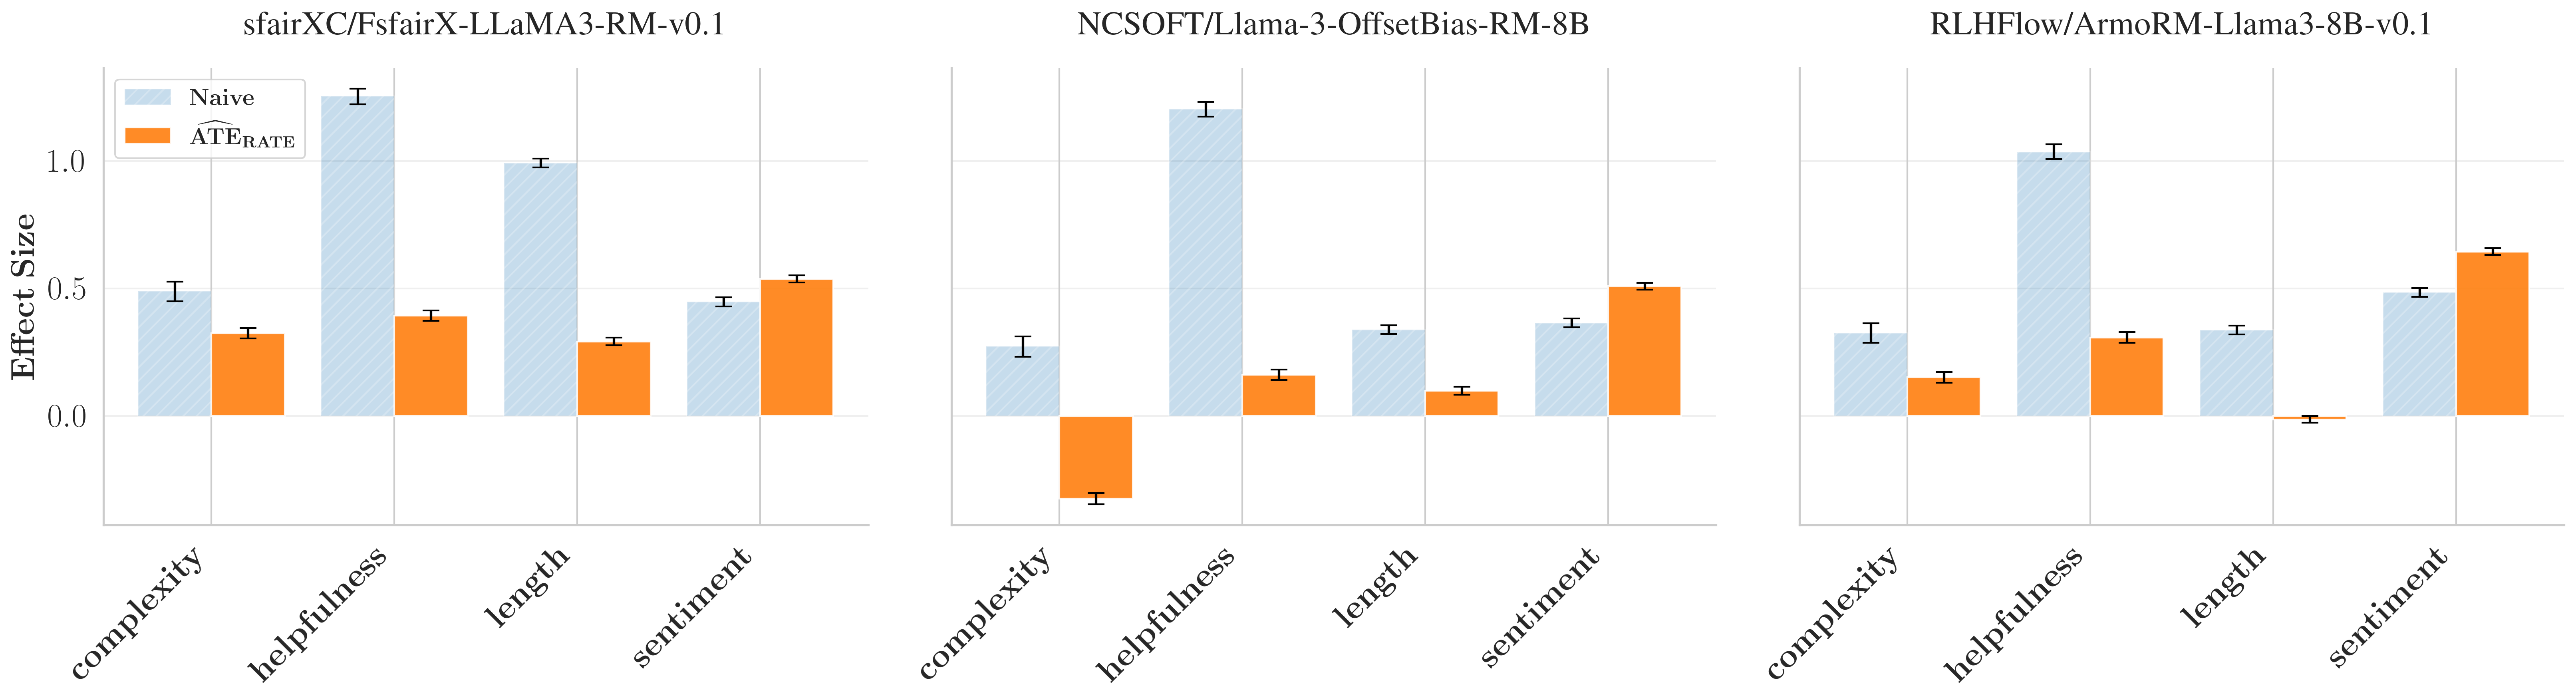

In [7]:
naive_vs_RATE(
    all_data=all_data,
    all_templates=all_templates,
    reward_models=REWARD_MODELS,
    normalize=True
)

In [8]:
all_data

[{'naive_effect': 1.324609282602708,
  'naive_effect_stderr': 0.01192538892765282,
  'ATE_single_rewrite': 0.6908812290673128,
  'ATE_single_rewrite_stderr': 0.005254430242160952,
  'ATT_single_rewrite': 0.05419359088949527,
  'ATT_single_rewrite_stderr': 0.004397918519562226,
  'ATU_single_rewrite': 1.3405609174019038,
  'ATU_single_rewrite_stderr': 0.007667693440318097,
  'ATE_rewritten_rewrite': 0.39030453628598316,
  'ATE_rewritten_rewrite_stderr': 0.010139742644725091,
  'ATT_rewritten_rewrite': 0.5365678994711223,
  'ATT_rewritten_rewrite_stderr': 0.013311674322598655,
  'ATU_rewritten_rewrite': 0.24105656834860234,
  'ATU_rewritten_rewrite_stderr': 0.015170974159443794,
  'reward_std': 1.3355473435068927,
  'Y1_count': 25253,
  'Y0_count': 24748,
  'concept': 'length',
  'score': 'sfairXC/FsfairX-LLaMA3-RM-v0.1'},
 {'naive_effect': 0.3756377664601436,
  'naive_effect_stderr': 0.009924219405942531,
  'ATE_single_rewrite': 0.31701136973354327,
  'ATE_single_rewrite_stderr': 0.0035

length


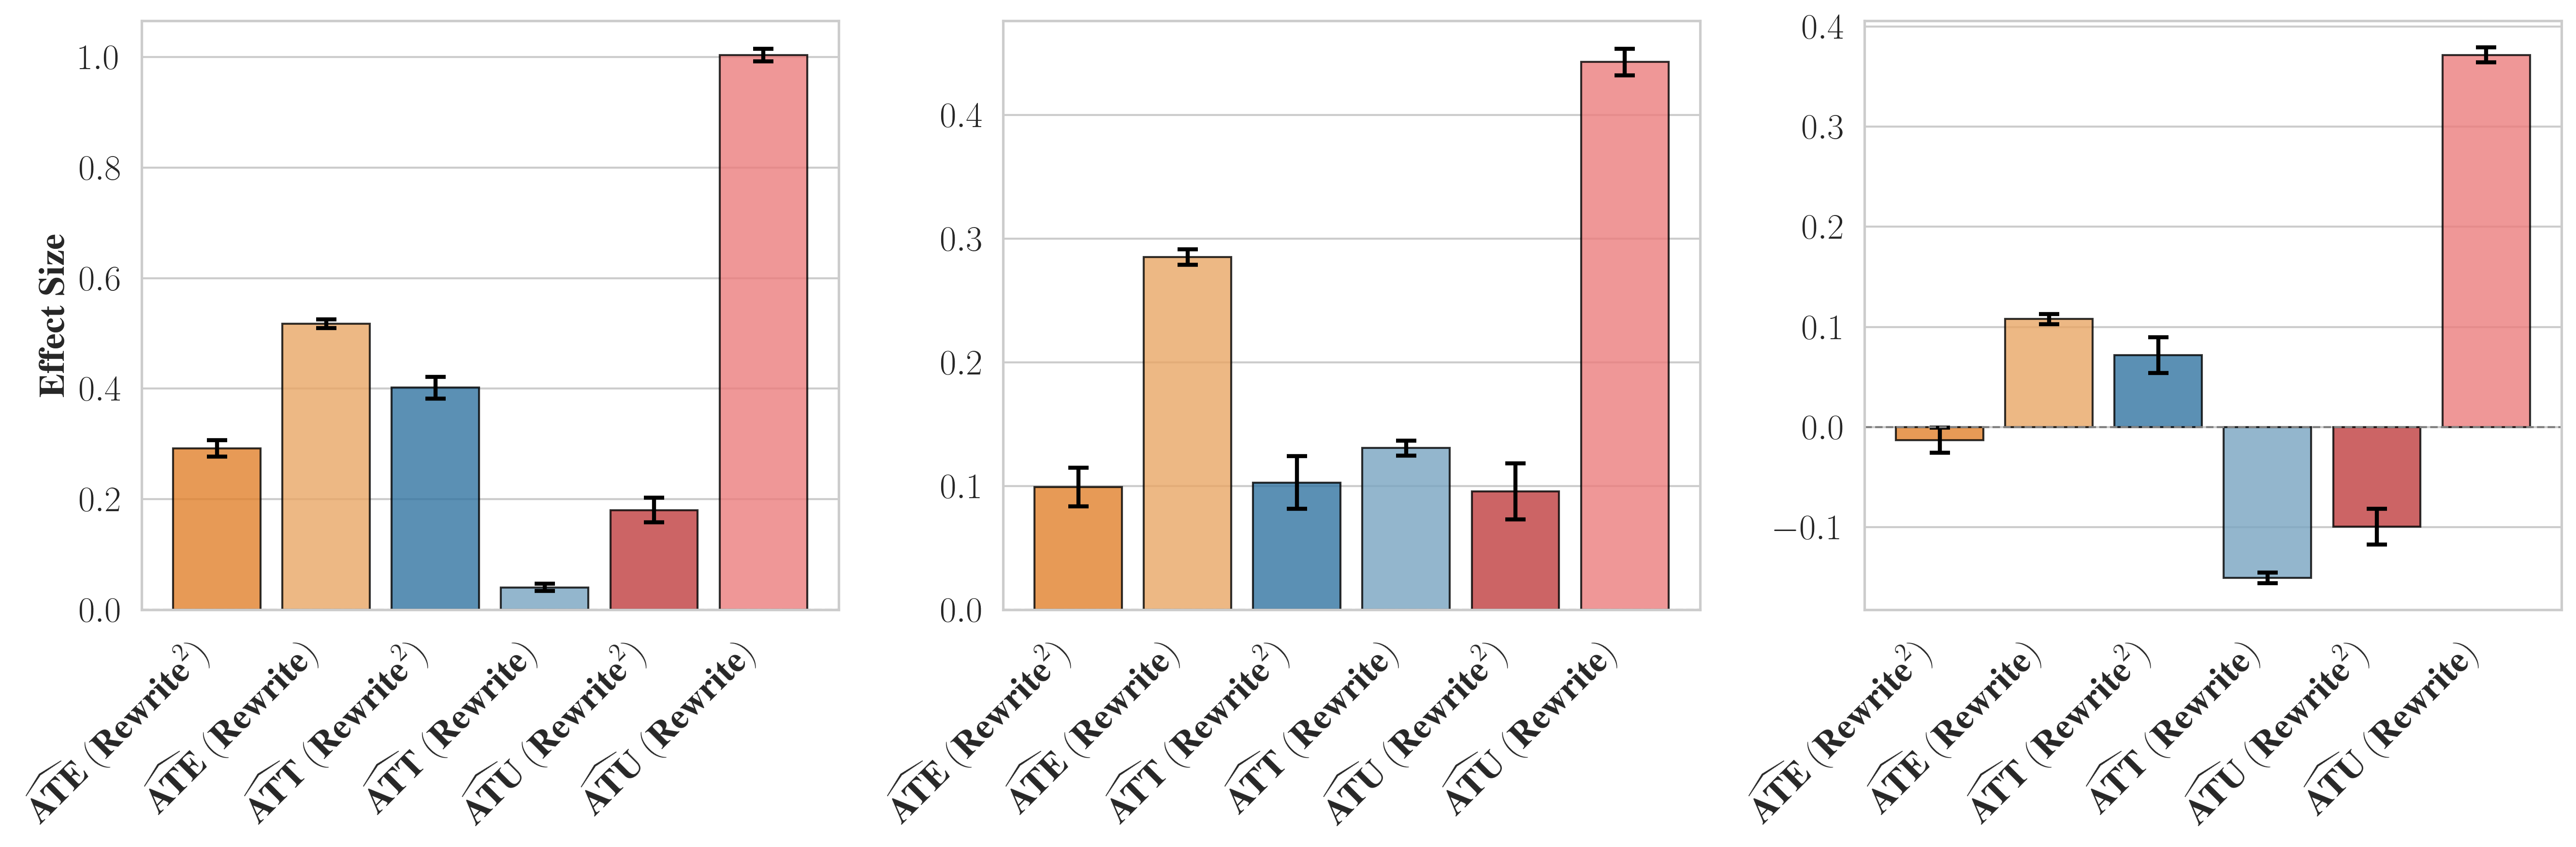

complexity


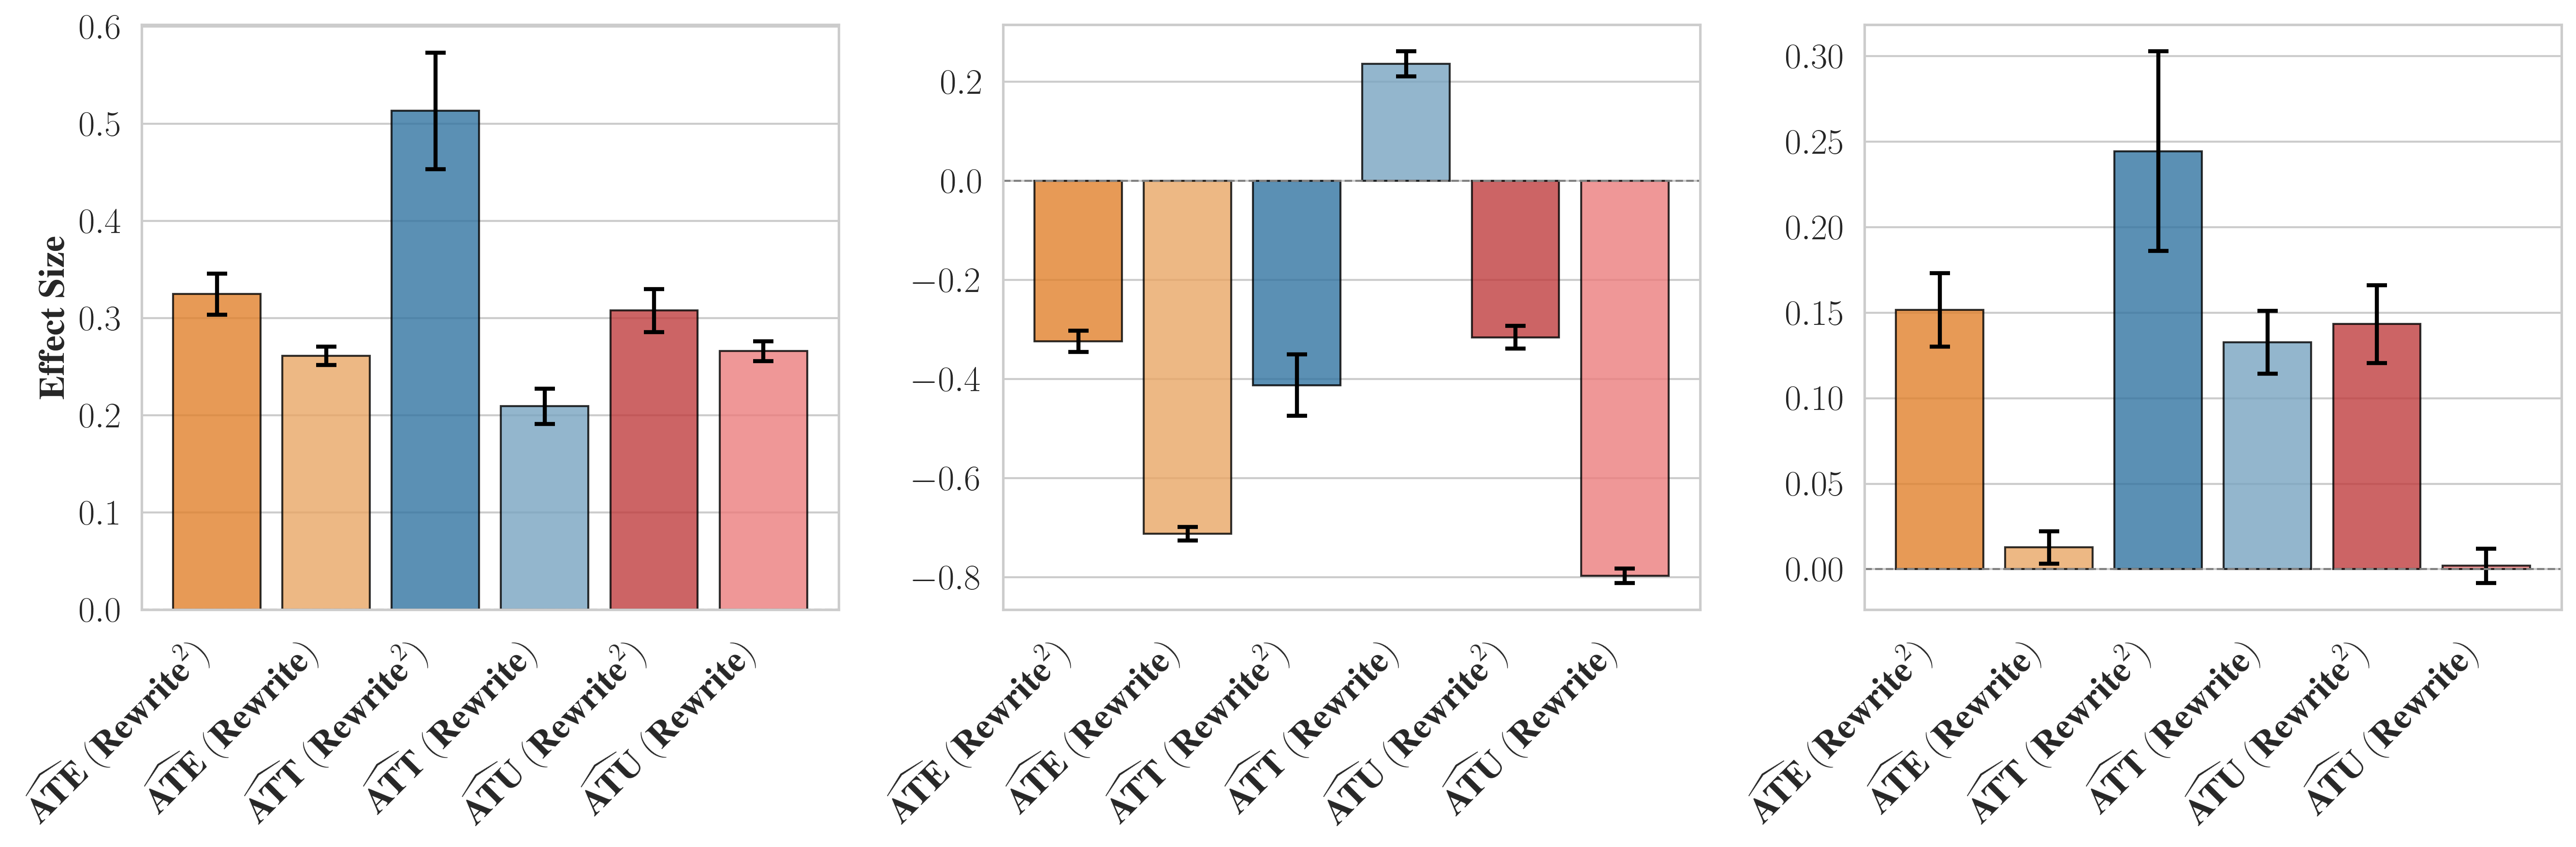

helpfulness


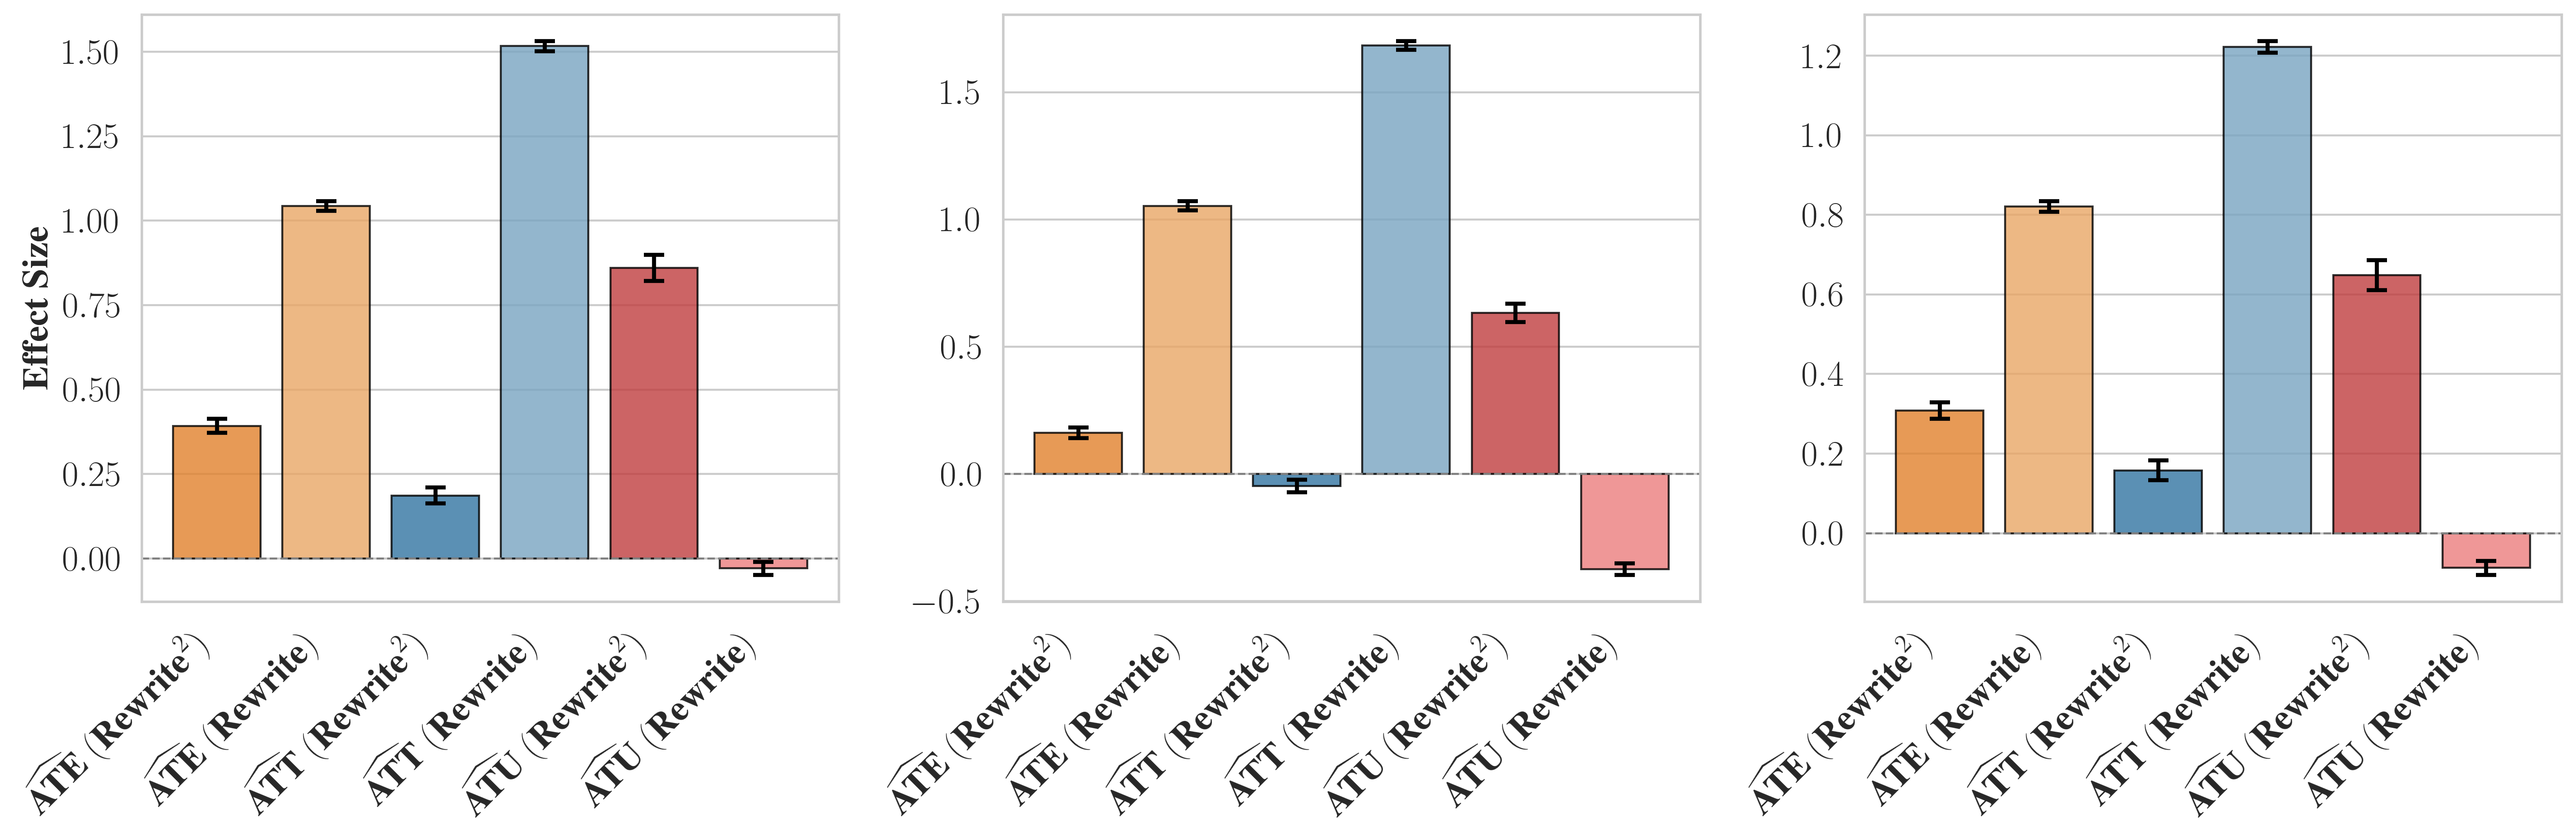

sentiment


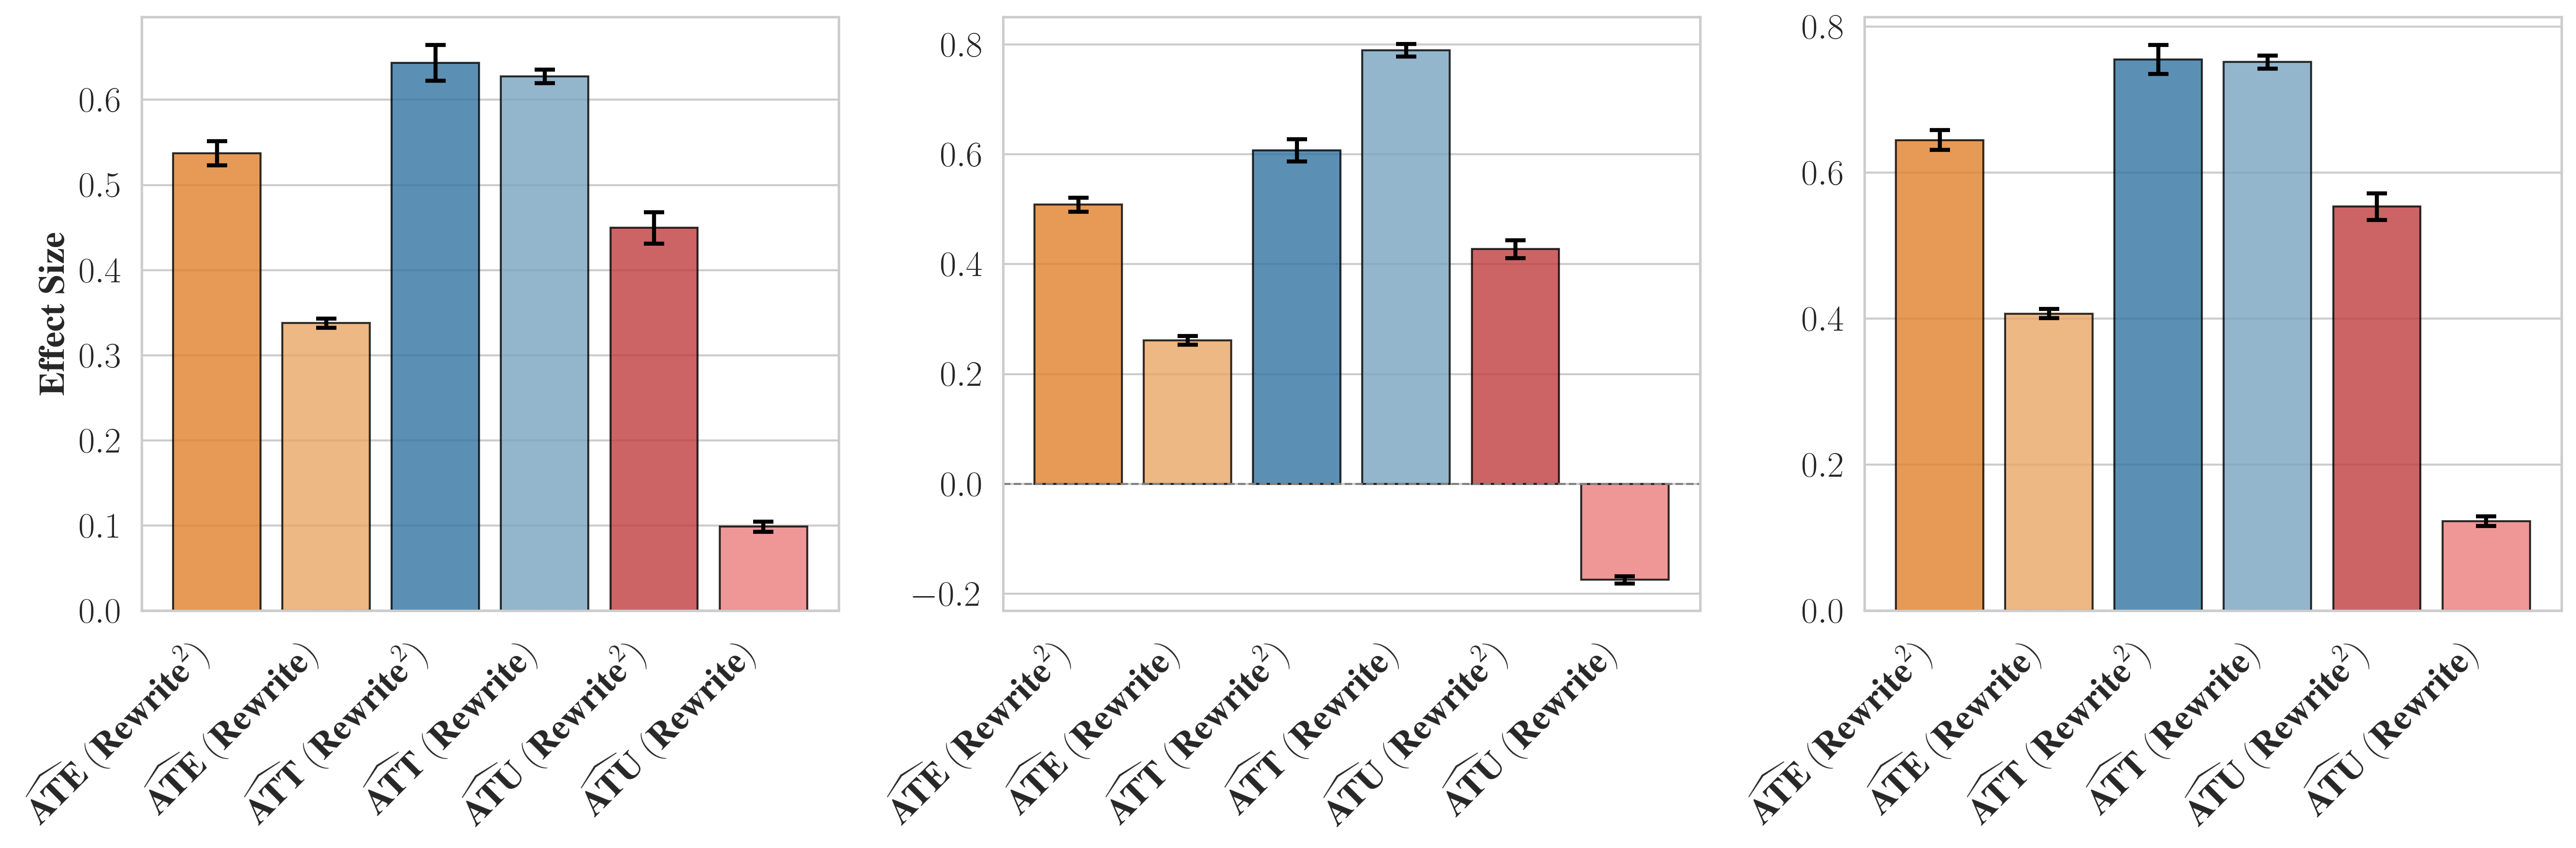

In [9]:
# for each concept, do this. we find "concept" in all_data and then filter by that
for concept in CONCEPTS.keys():
    effects_data = [d for d in all_data if d["concept"] == concept]
    
    # order them by "score" = "FsfairX-LLAMA3-RM-v0.1","NCSOFT/Llama-3-OffsetBias-RM-8B", "RLHFlow/ArmoRM-Llama3-8B-v0.1"
    ordered_effects_data = sorted(effects_data, key=lambda x: REWARD_MODELS.index(x["score"]))

    # print the concept
    print(concept)

    rewrite_bias(ordered_effects_data)

In [2]:
config = load_dataset_from_json(Path("config_plotting_synth.jsonl"))

# make into list of dictionaries
synthetic_templates = [value for value in config.values()]

In [3]:
# save all the data
synthetic_data = []
for effects_template in synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic" / "positive_long" / dataset_filename)
    effects = treatment_effects_pipeline(dataset, **effects_template)
    synthetic_data.append(effects)

2025-01-29 12:13:03,206 - INFO - Number of w=1 examples: 4004
2025-01-29 12:13:03,223 - INFO - Number of w=0 examples: 5372
2025-01-29 12:13:03,228 - INFO - Treatment effects: {   'ATE_rewritten_rewrite': 0.0844035465969567,
    'ATE_rewritten_rewrite_stderr': 0.04930379836414409,
    'ATE_single_rewrite': 0.16884899790376523,
    'ATE_single_rewrite_stderr': 0.01354892736882799,
    'ATT_rewritten_rewrite': 0.2384955123230651,
    'ATT_rewritten_rewrite_stderr': 0.06947906261246611,
    'ATT_single_rewrite': -0.330754465871043,
    'ATT_single_rewrite_stderr': 0.01630709816868453,
    'ATU_rewritten_rewrite': -0.0304483206344911,
    'ATU_rewritten_rewrite_stderr': 0.0685568950220651,
    'ATU_single_rewrite': 0.5412265610002531,
    'ATU_single_rewrite_stderr': 0.01873701381382012,
    'Y0_count': 5372,
    'Y1_count': 4004,
    'naive_effect': -0.2572232905938362,
    'naive_effect_stderr': 0.06290409599455854,
    'reward_std': 3.068588378397191}
2025-01-29 12:13:03,229 - INFO - Ca

In [4]:
config = load_dataset_from_json(Path("config_plotting_help_synth.jsonl"))

# make into list of dictionaries
help_synthetic_templates = [value for value in config.values()]

In [5]:
# save all the data
help_synthetic_data = []
for effects_template in help_synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic_helpsteer" / dataset_filename)
    effects = treatment_effects_pipeline(dataset, **effects_template)
    help_synthetic_data.append(effects)

2025-01-29 12:13:08,117 - INFO - Number of w=1 examples: 2574
2025-01-29 12:13:08,127 - INFO - Number of w=0 examples: 2574
2025-01-29 12:13:08,131 - INFO - Treatment effects: {   'ATE_rewritten_rewrite': 0.014393984818637143,
    'ATE_rewritten_rewrite_stderr': 0.00079378864033712,
    'ATE_single_rewrite': 0.01957111698185457,
    'ATE_single_rewrite_stderr': 0.0005043422673346951,
    'ATT_rewritten_rewrite': 0.0054083771461102825,
    'ATT_rewritten_rewrite_stderr': 0.0011309362696518663,
    'ATT_single_rewrite': 0.04116395636899113,
    'ATT_single_rewrite_stderr': 0.0006486281561102675,
    'ATU_rewritten_rewrite': 0.02337959249116403,
    'ATU_rewritten_rewrite_stderr': 0.0010911649065769267,
    'ATU_single_rewrite': -0.002021722405281992,
    'ATU_single_rewrite_stderr': 0.00048425794318990095,
    'Y0_count': 2574,
    'Y1_count': 2574,
    'naive_effect': 0.031895498183147755,
    'naive_effect_stderr': 0.000981691571743384,
    'reward_std': 0.03521797135263725}
2025-01-29

Slope of $\widehat{\textbf{ATE}}\ (\textbf{Rewrite}^2)$: 0.0468
Slope of $\widehat{\textbf{ATE}}\ (\textbf{Rewrite})$: -0.1001


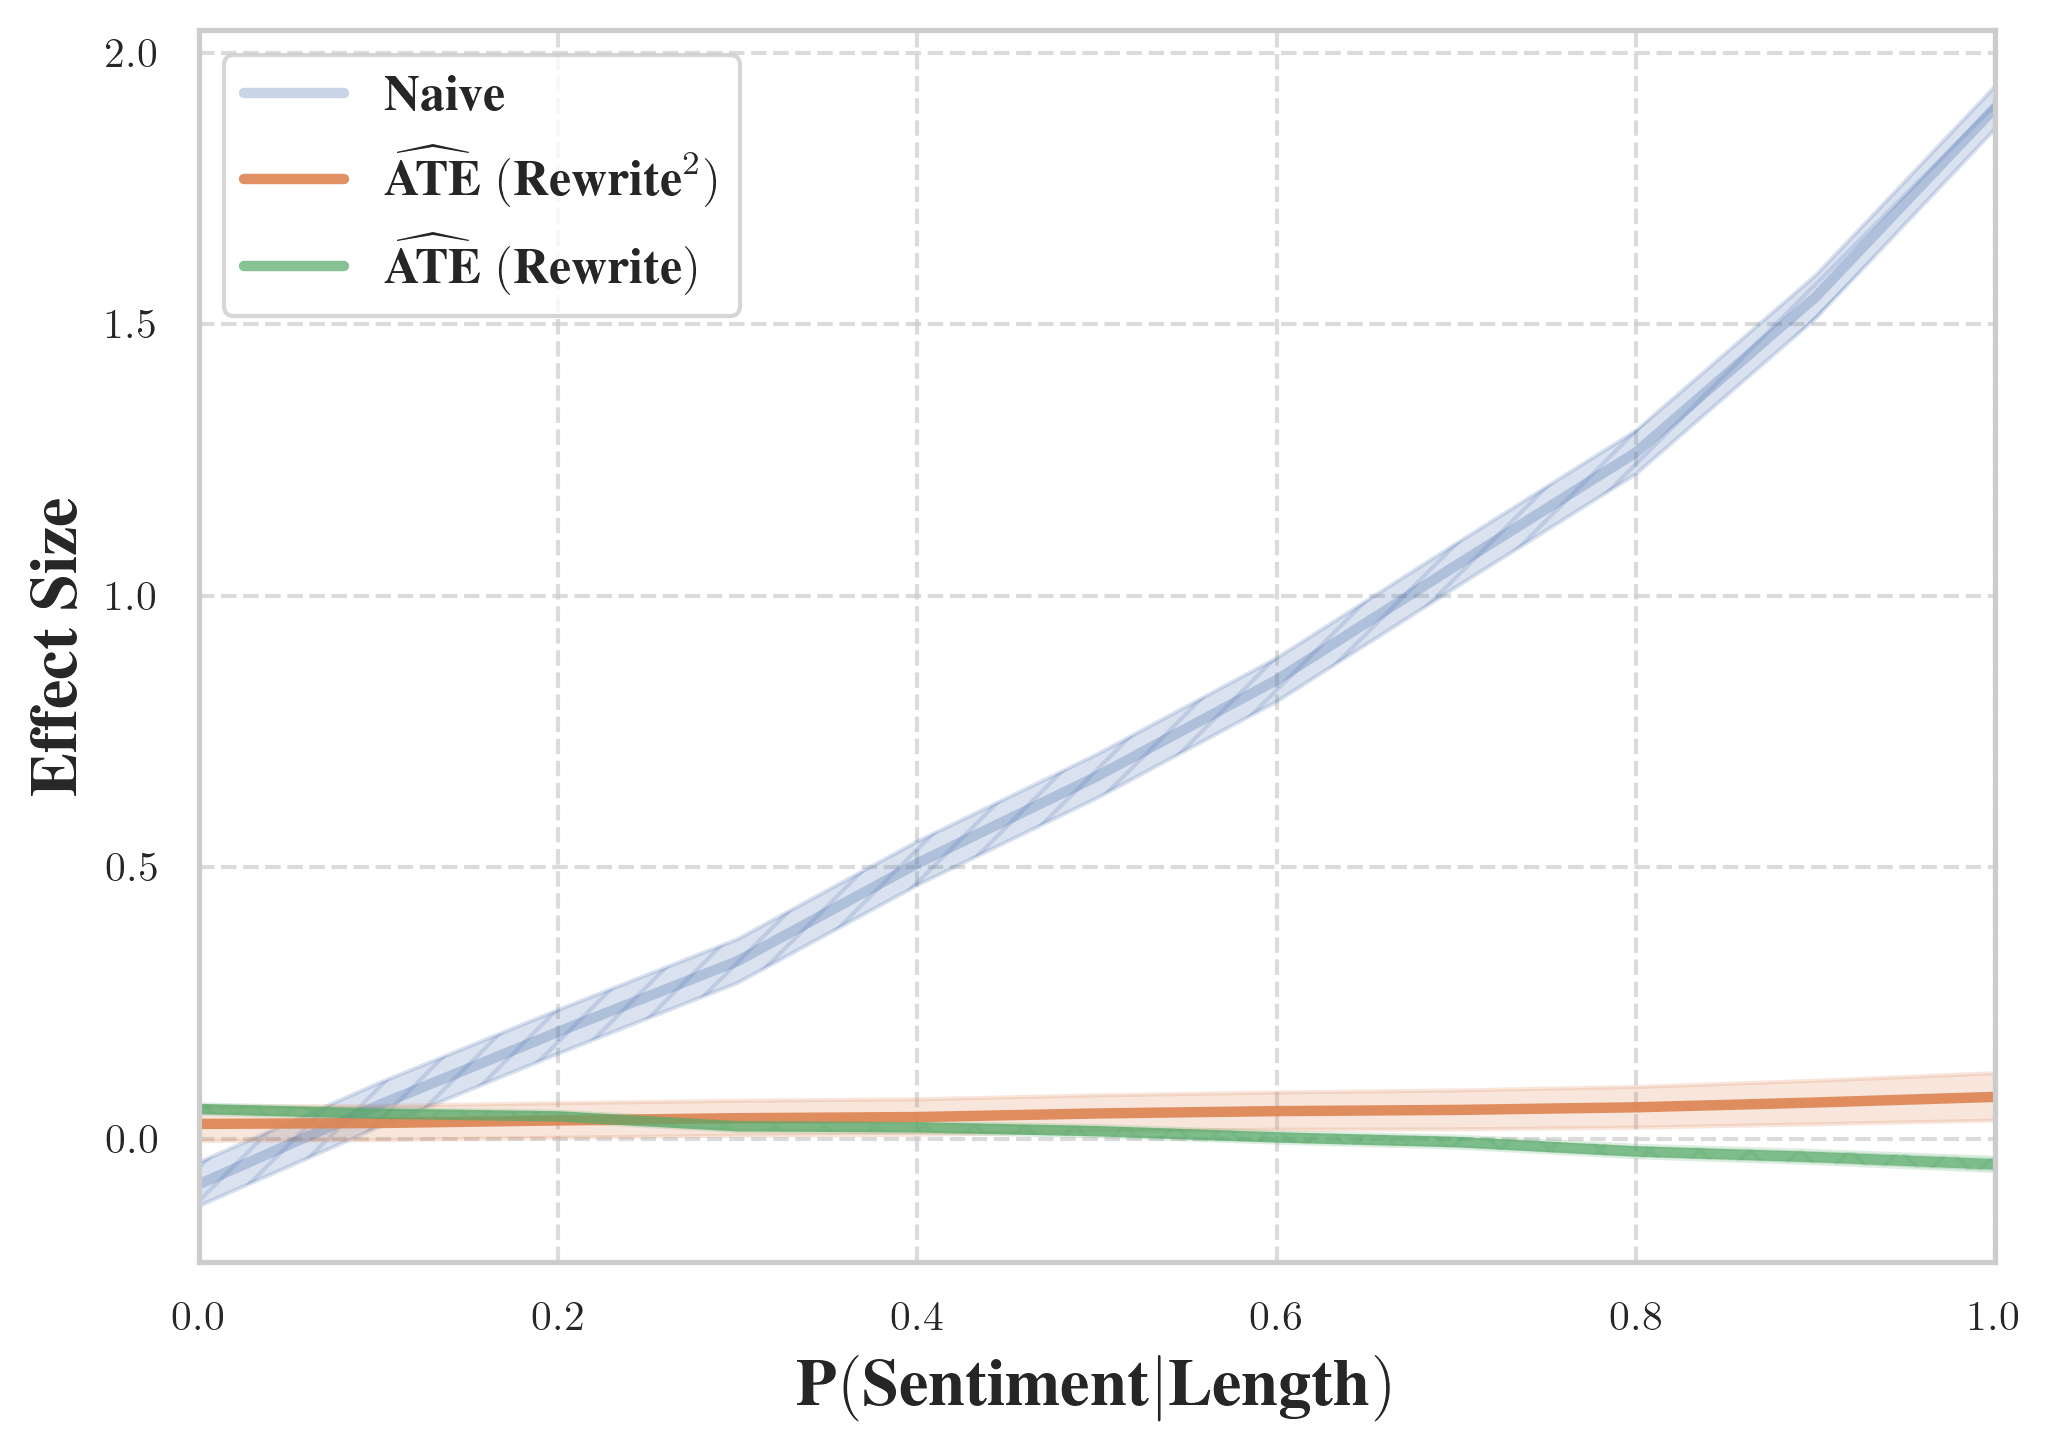

In [8]:
synthetic_plot(synthetic_data, synthetic_templates, "Length", "Sentiment", fr'$\textbf{{P}}(\textbf{{Sentiment}}|\textbf{{Length}})$')

Slope of $\widehat{\textbf{ATE}}\ (\textbf{Rewrite}^2)$: -0.0114
Slope of $\widehat{\textbf{ATE}}\ (\textbf{Rewrite})$: -0.0413


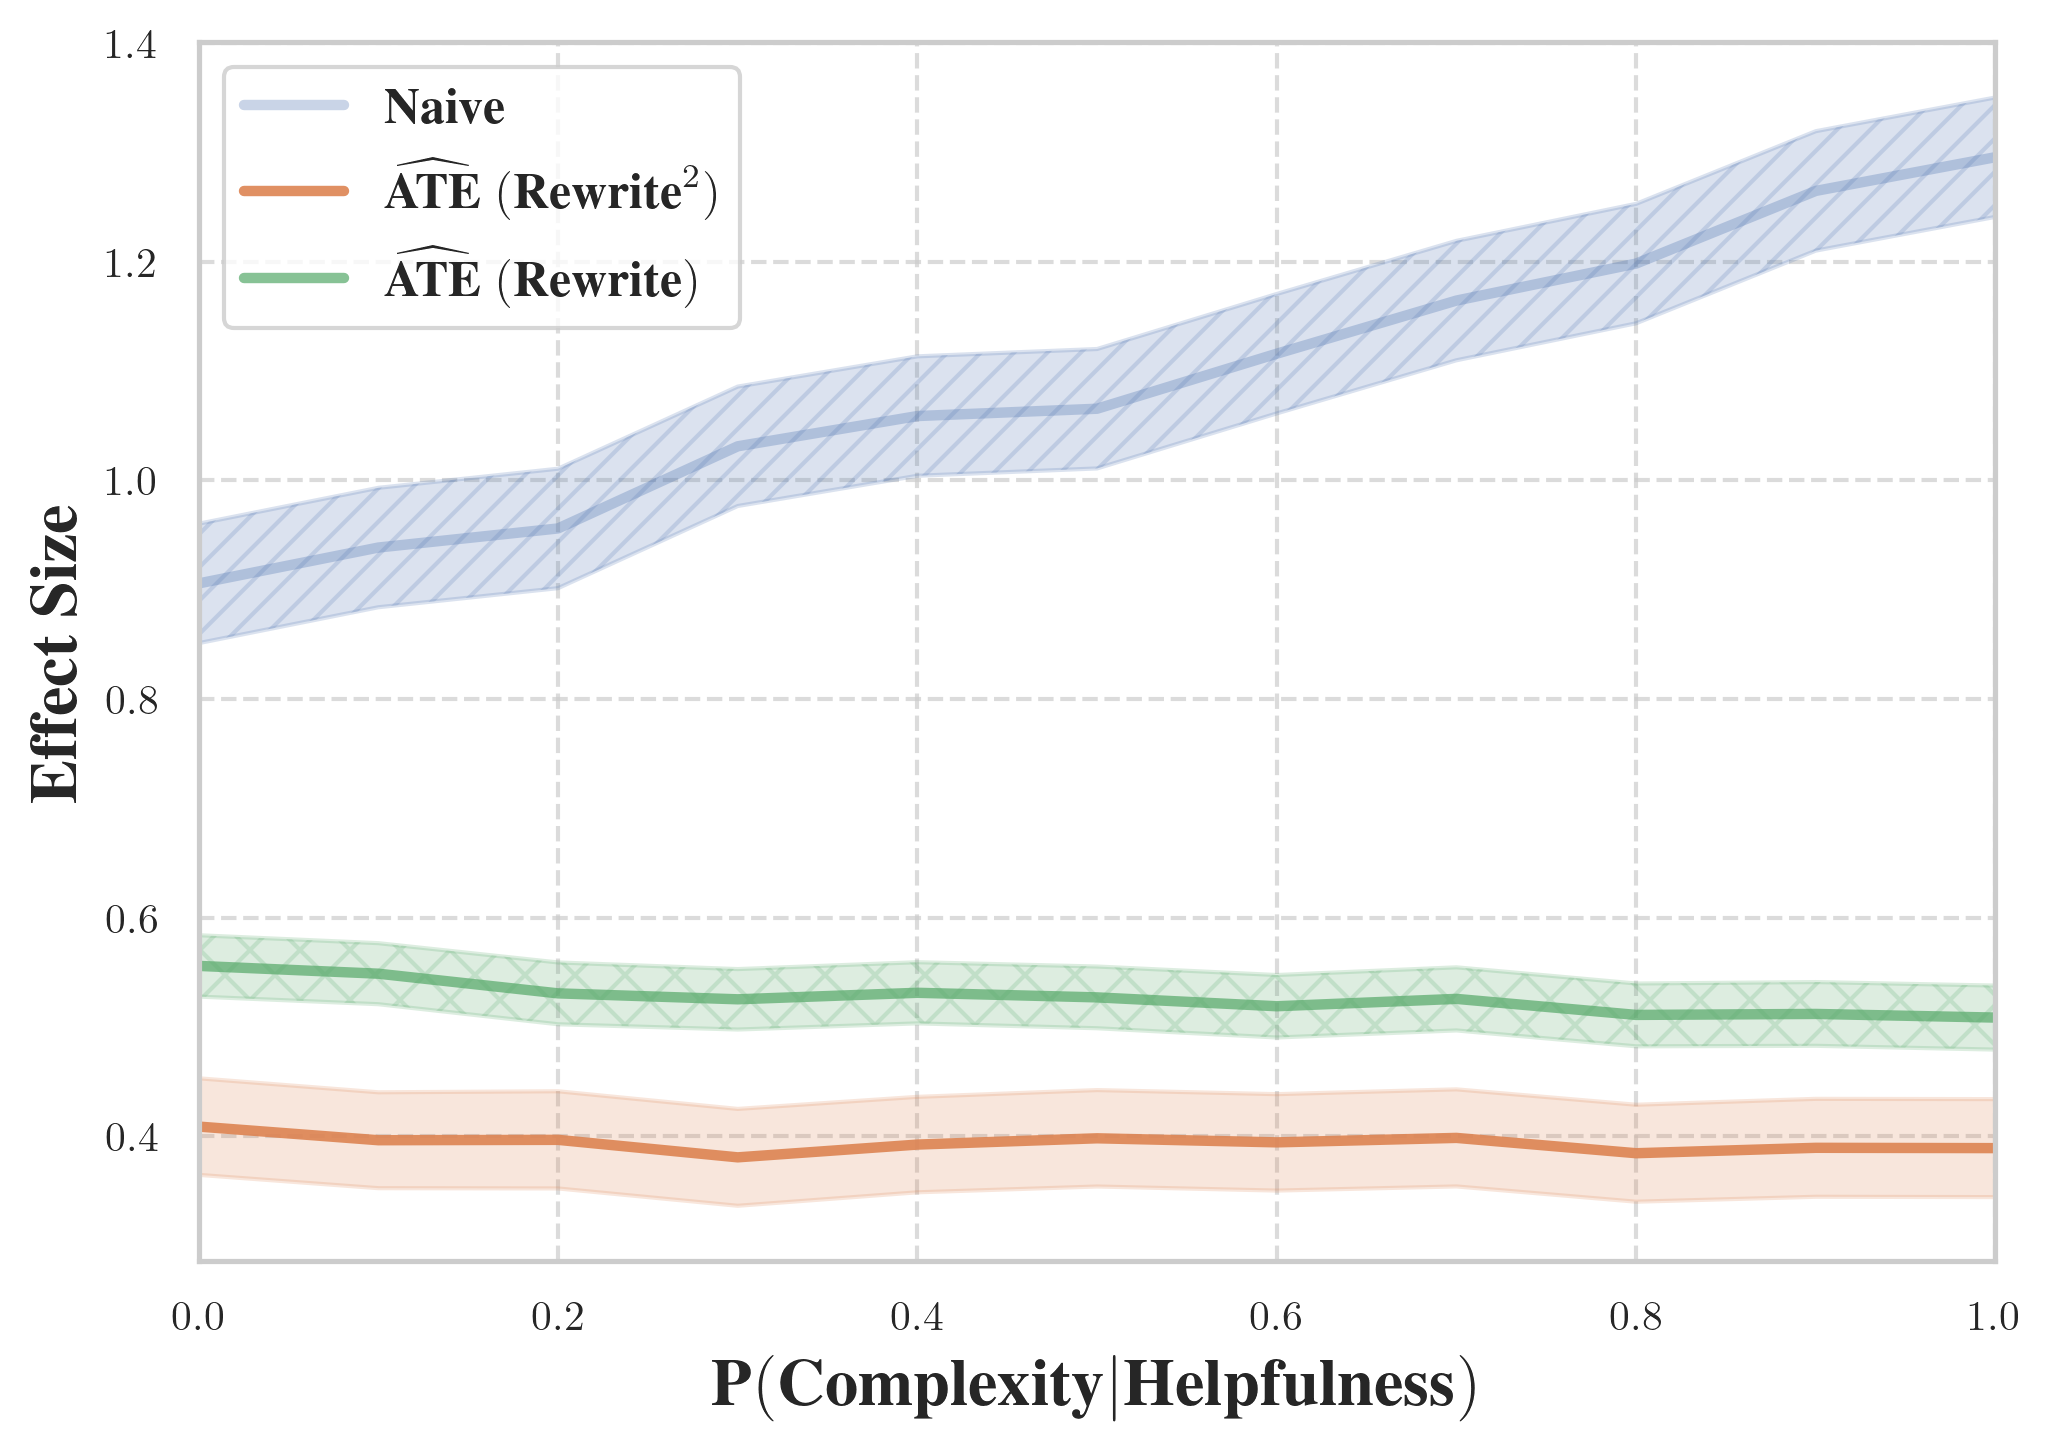

In [9]:
synthetic_plot(help_synthetic_data, help_synthetic_templates, "Helpfulness", "Complexity", fr'$\textbf{{P}}(\textbf{{Complexity}}|\textbf{{Helpfulness}})$')